In [1]:
# Calculations of accretion rates for Bondi-Hoyle-Lyttleton (BHL) 
# accretion model used in reference paper M. Ricotti et al. 
# https://arxiv.org/abs/0709.0524 and Park Ricotti Model (PR)
# accretion model as per F. Scarcella et al. 2020, 
# https://arxiv.org/abs/2012.10421 . 

# Here, the value of the speed of sound in the ioinized region of 
# PR Model is chosen as c_s,in = 25 c_s. c_s,in is the free parameter 
# of PR accretion Model.



# The values of v_pbh, c_s and v_eff are used as per 
# Vivian Poulin & Pasquale D. Serpico et al. 2007 
# https://arxiv.org/abs/1707.04206. 


# In this notebook, we consider PBHs with and without DM halos of density profile of 
# ρ(r) ∝ r^{-9/4} as per P. Jangra et al. https://arxiv.org/pdf/2304.05892.pdf


from scipy.integrate import quad
import numpy as np
from scipy.integrate import odeint
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import integrate
import matplotlib.ticker
from mpmath import *
from scipy.optimize import bisect, brentq, newton, root
from PRaccretion import*
import math
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

mp.dps = 25; mp.pretty = True

def c_s(z):
    return c_s_Ricotti(z)

def v_pbh(z):
    return v_rel_digitized_Ricotti(z)


def v_effA(z):
    def Mach_number(z):
        return v_pbh(z)/c_s(z)
    numerator = (2**(7/12)) * (Mach_number(z)**(7/6)) * c_s(z)
    first_term = np.sqrt(2) * (Mach_number(z) + Mach_number(z)**3)
    second_term = np.exp(1/(2 * (Mach_number(z)**2))) * np.sqrt(np.pi) * (-1 - 2 * (Mach_number(z)**2) + Mach_number(z)**4) * math.erfc(1/(np.sqrt(2) * Mach_number(z)))
    denominator = (first_term + second_term)**(1/6)
    return  numerator/denominator                                       
  
    
def v_effB(z):
    def Mach_number(z):
        return v_pbh(z)/c_s(z)
    numerator = np.sqrt(2) * np.exp(-1/(12 * (Mach_number(z)**2))) * (np.pi**(1/6))* (Mach_number(z)**(5/3)) * c_s(z)
    first_term = (1 + (2 * (Mach_number(z)**2))) * besselk(0, (1/(4 * (Mach_number(z)**2)))) 
    second_term = besselk(1, (1/(4 * (Mach_number(z)**2))))
    denominator = (first_term - second_term)**(1/3)
    return  numerator/denominator    




def v_eff(z):
    if A == True:
        return v_effA(z)
    else:
        return v_effB(z)


    
    
def x_e(z):
    if z < z_rec:
        return e_fraction
    else:
        return 1

    
    
    
# BHL accretion Model around isolated PBHs 
def r_B_pbh(z, m):
    return (G * m)/(v_eff(z)**2)

def β_cap_pbh(z, m): # Here, β_pbh = β(m_pbh)
    return 1e-4 * m * (((1+z)/1000)**(3/2)) * (((5.74e3 * (yr/pc))/v_eff(z))**3) * (0.257 + 1.45 * (x_e(z)/0.01) * (((1+z)/1000)**(5/2)))

def λ_pbh(z, m):
    def x_cr(z, m):
        return (-1 + math.sqrt(1 + β_cap_pbh(z, m)))/β_cap_pbh(z, m) 
    return math.exp((9/2)/(3 + β_cap_pbh(z, m)**(3/4))) * (x_cr(z, m)**2)

def M_dot_pbh_BHL(z, m):
    return 4 * np.pi * λ_pbh(z, m) *  ρ(z) * v_eff(z) * (r_B_pbh(z, m)**2)

def m_dot_pbh_BHL(z, m):
    return M_dot_pbh_BHL(z, m)/M_dot_Edd(z, m) 

def M_dot_pbh_BHL_by_dz(z, m):
    return M_dot_pbh_BHL(z, m) * (dt_dz(z))




# BHL accretion Model in the presence of DM halos around isolated PBHs  
def r_ta(z, m):
    if DM_profile94 == True:
        return r_ta_Jangra(z, m)
    else:
        return r_ta_kavanagh(z, m)

def M_halo(z, m): # Mass of the DM halo at turn around radius r_ta.
    if DM_profile94 == True:
        return M_halo_Jangra(z, m)
    else:
        return M_halo_Kavanagh(z, m)


def r_B_halo(z, m):
    return (G * M_halo(z, m))/(v_eff(z)**2)


def r_B_eff(z, m):
    if r_ta(z, m) <= r_B_halo(z, m):
        r_B_eff_var =  (r_B_halo(z, m) + r_B_pbh(z, m))
    else:
        def a(z, m):
             return  (r_B_halo(z, m)/(1-p)) * (1/(r_ta(z, m)**p))
        def b(z, m):
            return 1  +   (p/(1-p)) * (r_B_halo(z, m)/r_ta(z, m))
        def c(z, m):
            return   r_B_pbh(z, m)
        #For, x = r_B,eff
        x_upper_limit = r_B_pbh(z, m) + r_B_halo(z, m)
        x_lower_limit = r_B_pbh(z, m)
        roots = newton(lambda x: (a(z, m) * (x**p)) - b(z, m)*x + c(z, m), x_upper_limit)
        r_B_eff_var = roots
    return r_B_eff_var    
        

def β_cap_halo(z, m): # Here, β_halo = β(m_pbh + m_halo)
    return 1e-4 * (m + M_halo(z, m)) * (((1+z)/1000)**(3/2)) * (((5.74e3 * (yr/pc))/v_eff(z))**3) * (0.257 + 1.45 * (x_e(z)/0.01) * (((1+z)/1000)**(5/2)))

def λ_halo(z, m):
    def x_cr(z, m):
        return (-1 + math.sqrt(1 + β_cap_halo(z, m)))/β_cap_halo(z, m) 
    return math.exp((9/2)/(3 + β_cap_halo(z, m)**(0.75))) * (x_cr(z, m)**2)


def M_dot_halo_BHL(z, m):
    return 4 * np.pi * λ_halo(z, m) * ρ(z) * v_eff(z) * (r_B_eff(z, m)**(2))

def m_dot_halo_BHL(z, m):
    return M_dot_halo_BHL(z, m)/M_dot_Edd(z, m) 

def M_dot_halo_BHL_by_dz(z, m):
    return M_dot_halo_BHL(z, m) * (dt_dz(z))





# Definition of various parameters in the ionized region of
# PR accretion Model of F. Scarcella et al. https://arxiv.org/abs/2012.10421.
# Definition of various parameters in the ionized region of
# PR accretion Model of F. Scarcella et al. https://arxiv.org/abs/2012.10421.


# PR accretion Model around isolated PBHs 
free_parameter = 25
def c_s_in(z):
    return free_parameter * c_s(z)
def v_R(z):
    return  2 * c_s_in(z)
def v_D(z):
    return  (c_s(z)**2)/(2 * c_s_in(z))
def Δ(z):
    return (((v_pbh(z)**2) + (c_s(z)**2))**2) - (4 * (v_pbh(z)**2) * (c_s_in(z)**2)) 
def ρ_in_plus(z):
    return  ρ(z) * (((v_pbh(z)**2) + (c_s(z)**2) + np.sqrt(Δ(z)))/(2 * (c_s_in(z)**2)))
def ρ_in_minus(z):
    return ρ(z) * (((v_pbh(z)**2) + (c_s(z)**2) - np.sqrt(Δ(z)))/(2 * (c_s_in(z)**2)))
def ρ_in_0(z):
    return ρ(z) * (((v_pbh(z)**2) + (c_s(z)**2))/(2 * (c_s_in(z)**2)))
def ρ_in(z):
    if v_pbh(z) <= v_D(z):
        return ρ_in_plus(z)
    elif v_D(z) < v_pbh(z) < v_R(z):
        return ρ_in_0(z)
    else:
        return ρ_in_minus(z)

def v_in(z):
    if v_pbh(z) <= v_D(z):
        return (ρ(z)/ρ_in(z)) * v_pbh(z)
    elif v_D(z) < v_pbh(z) < v_R(z):
        return c_s_in(z)
    else:
        return (ρ(z)/ρ_in(z)) * v_pbh(z)

def v_eff_in(z):
    return np.sqrt((v_in(z)**2) + (c_s_in(z)**2))

def r_B_in(z, m):
    return (G * m)/(v_eff_in(z)**2)

def M_dot_pbh_PR(z, m):
    return 4 * np.pi  *  ρ_in(z) * v_eff_in(z) * (r_B_in(z, m)**2)

def m_dot_pbh_PR(z, m):
    return (M_dot_pbh_PR(z, m)/M_dot_Edd(z, m))

def M_dot_pbh_PR_by_dz(z, m):
    return M_dot_pbh_PR(z, m) * (dt_dz(z))



# PR accretion Model in the presence of DM halos around isolated PBHs  
def r_B_eff_in(z, m):
    def r_B_pbh_in(z, m):
        return (G * m)/(v_eff_in(z)**2)
    def r_B_halo_in(z, m):
        return (G * M_halo(z, m))/(v_eff_in(z)**2)
    if r_ta(z, m) <= r_B_halo_in(z, m):
        r_B_eff_in_var =  r_B_halo_in(z, m) + r_B_pbh_in(z, m)
    else:
        def a(z, m):
             return  (r_B_halo_in(z, m)/(1-p)) * (1/(r_ta(z, m)**p))
        def b(z, m):
            return 1  +   (p/(1-p)) * (r_B_halo_in(z, m)/r_ta(z, m))
        def c(z, m):
            return   r_B_pbh_in(z, m)
        #For, x = r_B,eff
        x_upper_limit = r_B_pbh_in(z, m) + r_B_halo_in(z, m)
        x_lower_limit = r_B_pbh_in(z, m)
        roots = newton(lambda x: (a(z, m) * (x**p)) - b(z, m)*x + c(z, m), x_upper_limit)
        r_B_eff_in_var = roots
    return r_B_eff_in_var    
         
        
def M_dot_halo_PR(z, m):
    return 4 * np.pi  *  ρ_in(z) * v_eff_in(z) * (r_B_eff_in(z, m)**2)

def m_dot_halo_PR(z, m):
    return (M_dot_halo_PR(z, m)/M_dot_Edd(z, m))

def M_dot_halo_PR_by_dz(z, m):
    return M_dot_halo_PR(z, m) * (dt_dz(z))

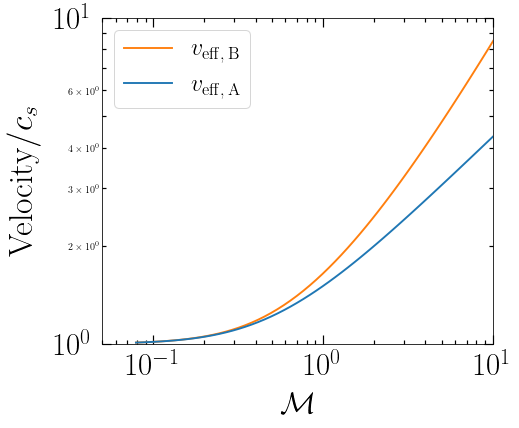

In [2]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (7, 6))
plt.rc('lines', linewidth = 1.9)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)

v_eff_arr_A = np.zeros(len(z_array))
v_eff_arr_B = np.zeros(len(z_array))
M_array = np.zeros(len(z_array))




for i, z in enumerate(z_array):
    M_array[i] = v_pbh(z)/c_s(z)
    v_eff_arr_A[i] = v_effA(z)/c_s(z)
    v_eff_arr_B[i] = v_effB(z)/c_s(z) 
    
    

    
            
          
ax.loglog(M_array, v_eff_arr_B, color = 'C1')        
ax.loglog(M_array, v_eff_arr_A, color = 'C0')




ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)

plt.xticks(fontsize = 31)
plt.yticks(fontsize = 31)


plt.xlim(0.05, 10)
plt.ylim(1, 10)

plt.legend([ r'$v_\mathrm{eff, \, B} $','$v_\mathrm{eff,\,A}$'],
           title_fontsize = 18, loc = 'upper left', prop = {"size":24})



plt.ylabel(r"Velocity$/c_{s}$ ", fontsize = 34, labelpad = 13)
plt.xlabel(r"$\mathcal{M}$", fontsize = 30, labelpad = 13)
plt.savefig('velocities_full.pdf', bbox_inches = 'tight')


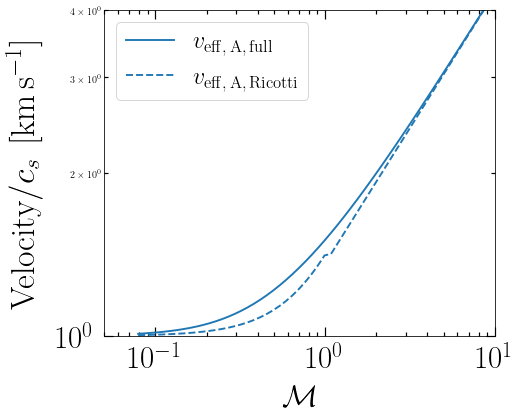

In [3]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (7, 6))
plt.rc('lines', linewidth = 1.9)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)

v_eff_arr_A = np.zeros(len(z_array))
v_eff_arr_A_Ricotti = np.zeros(len(z_array))
M_array = np.zeros(len(z_array))




for i, z in enumerate(z_array):
    M_array[i] = v_pbh(z)/c_s(z)
    v_eff_arr_A[i] = v_effA(z)/c_s(z)
    v_eff_arr_A_Ricotti[i] = v_effA_Ricotti(z)/c_s(z)

          
        
ax.loglog(M_array, v_eff_arr_A, color = 'C0')       
ax.loglog(M_array, v_eff_arr_A_Ricotti, color = 'C0', ls = '--')



ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)

plt.xticks(fontsize = 31)
plt.yticks(fontsize = 31)


plt.xlim(0.05, 10)
plt.ylim(1, 4)

plt.legend([ r'$v_\mathrm{eff, \, A, \, full} $','$v_\mathrm{eff,\,A,\,Ricotti}$'],
           title_fontsize = 18, loc = 'upper left', prop = {"size":24})



plt.ylabel(r"Velocity$/c_{s}\,\: \mathrm{[km \,s^{-1}}]$ ", fontsize = 34, labelpad = 13)
plt.xlabel(r"$\mathcal{M}$", fontsize = 30, labelpad = 13)
plt.savefig('velocities_fullA.pdf', bbox_inches = 'tight')

/home/pratibhajangra/Desktop/ Project 2/4. Final Calculations/3. DM94/PRaccretion.py:249: RuntimeWarning: invalid value encountered in double_scalars
  return  c_s_Ricotti(z) * Mach_number(z) * ((math.sqrt(2/math.pi) * np.log((2/math.e)*              Mach_number(z)))**(-1/3))


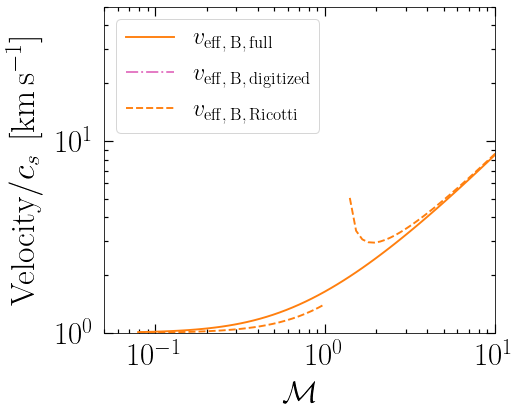

In [4]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (7, 6))
plt.rc('lines', linewidth = 1.9)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)

v_eff_arr_B = np.zeros(len(z_array))
v_eff_arr_B_digitized = np.zeros(len(z_array))
v_eff_arr_B_Ricotti = np.zeros(len(z_array))
M_array = np.zeros(len(z_array))




for i, z in enumerate(z_array):
    M_array[i] = v_pbh(z)/c_s(z)
    v_eff_arr_B[i] = v_effB(z)/c_s(z)
    v_eff_arr_B_digitized[i] = veffB_extrapolation(z)/c_s(z) 
    v_eff_arr_B_Ricotti[i] = v_effB_Ricotti(z)/c_s(z)
         
          
        
ax.loglog(M_array, v_eff_arr_B, color = 'C1') 
ax.loglog(M_array, v_eff_arr_B_digitized, color = 'C6', ls = '-.')
ax.loglog(M_array, v_eff_arr_B_Ricotti, color ='C1', ls = '--')




ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)

plt.xticks(fontsize = 31)
plt.yticks(fontsize = 31)


plt.xlim(0.05, 10)
plt.ylim(1, 50)

plt.legend([ r'$v_\mathrm{eff, \, B, \, full} $','$v_\mathrm{eff,\,B,\,digitized}$', '$v_\mathrm{eff,\,B,\,Ricotti}$'],
           title_fontsize = 18, loc = 'upper left', prop = {"size":24})



plt.ylabel(r"Velocity$/c_{s}\,\: \mathrm{[km \,s^{-1}}]$ ", fontsize = 34, labelpad = 13)
plt.xlabel(r"$\mathcal{M}$", fontsize = 30, labelpad = 13)
plt.savefig('velocities_fullB.pdf', bbox_inches = 'tight')

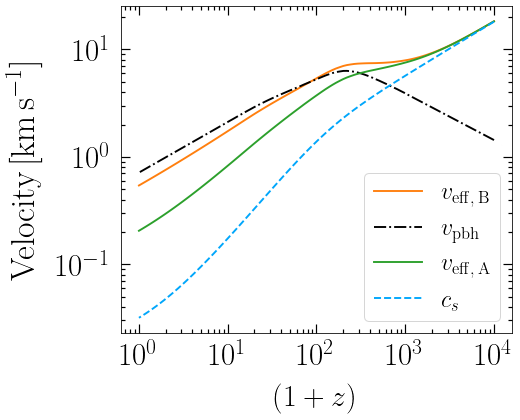

In [5]:
colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (7, 6))
plt.rc('lines', linewidth = 1.9)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)

v_eff_arr_A = np.zeros(len(z_array))
v_eff_arr_B = np.zeros(len(z_array))
cs_array = np.zeros(len(z_array))
v_pbh_array = np.zeros(len(z_array))
v_eff_arr = np.zeros(len(z_array))

e_fraction = 1e-3





for i, z in enumerate(z_array):
    v_eff_arr_A[i] = v_effA(z) * (pc/yr) * 1e-3
    v_eff_arr_B[i] = v_effB(z) * (pc/yr) * 1e-3
    cs_array[i] = c_s(z) * (pc/yr) * 1e-3  
    v_pbh_array[i] = v_pbh(z) * (pc/yr) * 1e-3 
    
             
ax.loglog(z_array, v_eff_arr_B, color = 'C1')        
ax.loglog(z_array, v_pbh_array, 'k', ls = '-.') 
ax.loglog(z_array, v_eff_arr_A, color = 'C2')

ax.loglog(z_array, cs_array, '#00a6fb', ls = '--')



ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)

plt.xticks(fontsize = 31)
plt.yticks(fontsize = 31)




plt.legend([ r'$v_\mathrm{eff, \, B} $', r'$v_\mathrm{pbh}$','$v_\mathrm{eff,\,A}$', '$c_{s}$'],
           title_fontsize = 18, loc = 'lower right', prop = {"size":24})



plt.ylabel(r"Velocity$\, \mathrm{[km \,s^{-1}}]$ ", fontsize = 34, labelpad = 13)
plt.xlabel(r"$\left(1+z\right)$", fontsize = 30, labelpad = 13)
plt.savefig('velocities_full.pdf', bbox_inches = 'tight')


In [2]:
# Calculations of the accretion parameters and accretion rate 
# as per the DM density profile of ρ(r) ∝ r^{-9/4}.

DM_profile94 = True
alpha = 9/4
p = 3 - alpha

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

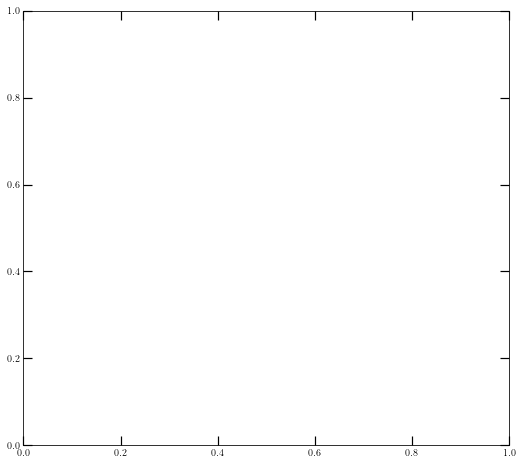

In [3]:
# Plots of m_dot in BHL model with and without the presence of
# DM halos for x_e = 1e-3.

colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (8.7, 8))
plt.rc('lines', linewidth = 3.1)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



A = False

mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_pbh_arr = np.zeros(len(z_array))
m_dot_halo_arr = np.zeros(len(z_array))



e_fraction = 1

for j, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_pbh_arr[i] = m_dot_pbh_BHL(z, m)
        m_dot_halo_arr[i] = m_dot_halo_BHL(z, m)
    ax.loglog(z_array, m_dot_halo_arr, color = color)
    ax.loglog(z_array, m_dot_pbh_arr, color = color, ls = '--')
    

#plt.text(1.5, 70, '$x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 29)
plt.xlabel(r'$\left(1+z\right)$',  fontsize = 38, labelpad = 10)
plt.ylabel(' $\dot m $', fontsize = 49, labelpad = 10)
plt.xticks(fontsize = 38)
plt.yticks(fontsize = 38)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "With DM halo", "Without DM halo"], title = 'BHL Model',
        title_fontsize = 28, loc = (1.02, 0.7), prop = {"size":22})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 32, loc = (1.02, 0.057), prop = {"size":23})
ax.add_artist(legend1)
ax.add_artist(legend2)



plt.title(r'$\rho_{h}(r) \propto r^{-9/4}$', fontsize = 44, pad = 14)
#plt.savefig('m_dot_BHL_Ricotti_xe1.pdf', bbox_inches = 'tight')
plt.show()

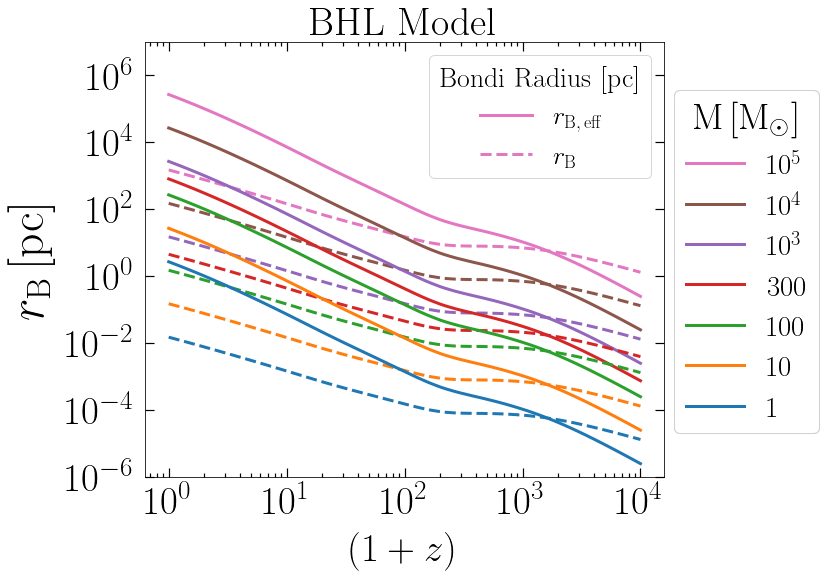

In [5]:
# Calculation of the effective Bondi Radius due to the presence of DM halo
# around the PBH

colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (9.3, 8))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_arr = np.geomspace(1, 1e4, 100)


r_B_pbh_arr = np.zeros(len(z_arr))
r_B_eff_arr = np.zeros(len(z_arr))




for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for j, z in enumerate(z_arr):
        r_B_pbh_arr[j] = r_B_pbh(z, m)
        r_B_eff_arr[j] = r_B_halo(z, m)
    ax.loglog(z_arr, r_B_eff_arr, color = color)
    ax.loglog(z_arr, r_B_pbh_arr, color = color, ls = '--')
    

    
#r_\mathrm{B} \equiv r_\mathrm{B, \,pbh}
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)               
lines = ax.get_lines()             
legend1 = plt.legend([lines[i] for i in [0, 1]], ["$r_\mathrm{B, \,eff}$","$r_\mathrm{B}  $"], title = 'Bondi Radius $ \mathrm{[pc]}$',
        title_fontsize = 28, loc = 'upper right', prop = {"size":26})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 37, loc = (1.02, 0.10), prop = {"size":29})
ax.add_artist(legend1)
ax.add_artist(legend2)


plt.ylim(1e-6, 1e7)
plt.xlabel(r'$\left(1+z\right)$', fontsize = 39, labelpad = 10)
plt.ylabel(r"$r_\mathrm{B}\, \mathrm{[pc]}$ ", fontsize = 48, labelpad = 11)
plt.xticks(fontsize = 39)
plt.yticks(fontsize = 39)

#$\rho_{h}(r) \propto r^{-9/4}$
plt.title(r'BHL Model', fontsize = 40, pad = 4)
#plt.savefig('r_B_eff_BHL.pdf', bbox_inches = 'tight')
plt.show()